In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

import shap

plt.style.use("seaborn-v0_8-darkgrid")


In [18]:
from ml_market.data import fetch_ohlcv, load_sector_data, load_macro_data
from ml_market.features import compute_all_features

TICKERS = [
    'NVDA',
    'MSFT',
    'AAPL',
    'AVGO',
    'AMZN',
    'TSLA',
    'META',
    'GOOGL',
    'GOOG',
    'NFLX',
]
START = "2015-01-01"
END = "2025-01-01"

# Load data
stocks_df = fetch_ohlcv(TICKERS, START, END)
sector_df = load_sector_data(start=START, end=END)
macro_df = load_macro_data(start=START, end=END)

df = compute_all_features(stocks_df, sector_df, macro_df)
print(f"Shape: {df.shape}")

# map tickers -> integer codes
unique_tickers = sorted(df['ticker'].unique())
ticker_to_code = {t: i for i, t in enumerate(unique_tickers)}
df['ticker_code'] = df['ticker'].map(ticker_to_code)
# drop ticker string
df = df.drop(columns=['ticker'])
# move ticker_code to first col
cols = ["ticker_code"] + [c for c in df.columns if c != "ticker_code"]
df = df[cols]

print("Ticker mapping:", ticker_to_code)
print(f"Final shape with ticker_code: {df.shape}")

df = df.sort_values(['date', 'ticker_code'])
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape: (23140, 112)
Ticker mapping: {'AAPL': 0, 'AMZN': 1, 'AVGO': 2, 'GOOG': 3, 'GOOGL': 4, 'META': 5, 'MSFT': 6, 'NFLX': 7, 'NVDA': 8, 'TSLA': 9}
Final shape with ticker_code: (23140, 112)


,ticker_code,date,open,high,low,close,volume,lag0_return_1d,lag1_return_1d,lag5_return_1d,...,dxy_ret_1d,dxy_vol_20,dxy_mom_10,vix_close,vix_ret_1d,vix_vol_20,vix_mom_10,spread_stock_vs_sector,spread_stock_vs_spy,spread_qqq_vs_spy
0,0,2015-10-16,25.095499,25.144891,24.814864,24.929363,156930400,-0.007330,0.014971,0.023927,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.009240,-0.011877,-0.000367
1,1,2015-10-16,28.263500,28.547001,28.015499,28.538000,86316000,0.014793,0.032322,0.012454,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,0.012883,0.010246,-0.000367
2,2,2015-10-16,9.307851,9.313959,9.155138,9.244475,19866000,-0.006564,0.037545,0.001885,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.008474,-0.011110,-0.000367
3,3,2015-10-16,32.979812,33.022519,32.636659,32.884960,32222000,0.000695,0.016248,0.006962,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.001215,-0.003851,-0.000367
4,4,2015-10-16,34.531829,34.572549,34.218988,34.527855,36316000,0.003319,0.018533,0.006357,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,0.001409,-0.001227,-0.000367


In [19]:
df = compute_all_features(stocks_df, sector_df, macro_df)
print(f"Initial dataframe shape: {df.shape}")

# map tickers → integer codes
unique_tickers = sorted(df["ticker"].unique())
ticker_to_code = {t: i for i, t in enumerate(unique_tickers)}
df["ticker_code"] = df["ticker"].map(ticker_to_code)

df = df.drop(columns=["ticker"])
df = df[["ticker_code"] + [c for c in df.columns if c != "ticker_code"]]
df = df.sort_values(["date", "ticker_code"]).reset_index(drop=True)

print("Ticker mapping:", ticker_to_code)
df.head()


Initial dataframe shape: (23140, 112)
Ticker mapping: {'AAPL': 0, 'AMZN': 1, 'AVGO': 2, 'GOOG': 3, 'GOOGL': 4, 'META': 5, 'MSFT': 6, 'NFLX': 7, 'NVDA': 8, 'TSLA': 9}


,ticker_code,date,open,high,low,close,volume,lag0_return_1d,lag1_return_1d,lag5_return_1d,...,dxy_ret_1d,dxy_vol_20,dxy_mom_10,vix_close,vix_ret_1d,vix_vol_20,vix_mom_10,spread_stock_vs_sector,spread_stock_vs_spy,spread_qqq_vs_spy
0,0,2015-10-16,25.095499,25.144891,24.814864,24.929363,156930400,-0.007330,0.014971,0.023927,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.009240,-0.011877,-0.000367
1,1,2015-10-16,28.263500,28.547001,28.015499,28.538000,86316000,0.014793,0.032322,0.012454,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,0.012883,0.010246,-0.000367
2,2,2015-10-16,9.307851,9.313959,9.155138,9.244475,19866000,-0.006564,0.037545,0.001885,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.008474,-0.011110,-0.000367
3,3,2015-10-16,32.979812,33.022519,32.636659,32.884960,32222000,0.000695,0.016248,0.006962,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,-0.001215,-0.003851,-0.000367
4,4,2015-10-16,34.531829,34.572549,34.218988,34.527855,36316000,0.003319,0.018533,0.006357,...,0.001801,0.004504,-0.013461,15.05,-0.062305,0.075163,-0.28128,0.001409,-0.001227,-0.000367


In [20]:
KEEP_FEATURES = [
    "ticker_code",
    "qqq_ret_1d", "xlk_ret_1d", "spy_ret_1d",
    "spread_qqq_vs_spy", "spread_stock_vs_sector",
    "volume_obv", "volume_obv_sma_20d", "volume_obv_ratio",
    "volume", "volume_sma_20d", "volume_change_1d",
    "lag0_return_1d", "lag1_return_1d", "lag5_return_1d",
    "return_rolling_std_20d",
    "return_volatility_ratio_5d_20d",
    "volatility_true_range", "volatility_atr_percent",
]

# Raw target (1-day forward return)
y_raw = df["target_return_1d"]

# Volatility-normalized target (model target)
df["target_volnorm"] = df["target_return_1d"] / df["return_rolling_std_20d"]

X = df[KEEP_FEATURES]
y = df["target_volnorm"]
dates = df["date"]

print("Feature matrix:", X.shape)


Feature matrix: (23140, 19)


In [21]:
def make_walkforward_splits(dates, train_size=1500, test_size=90, embargo=10):
    """
    Standard walk-forward expanding-window with embargo.
    """
    unique_dates = np.array(sorted(dates.unique()))
    N = len(unique_dates)

    splits = []
    i = 0

    while i + train_size + embargo + test_size <= N:
        train_dates = unique_dates[i : i + train_size]
        test_dates  = unique_dates[i + train_size + embargo :
                                   i + train_size + embargo + test_size]

        train_mask = dates.isin(train_dates)
        test_mask  = dates.isin(test_dates)

        splits.append((train_mask, test_mask))
        i += test_size

    return splits

splits = make_walkforward_splits(dates, 1500, 90, 10)
print("Number of walk-forward splits:", len(splits))


Number of walk-forward splits: 8


In [22]:
def evaluate_model(model, X, y_norm, y_raw, df_std, dates, splits):
    metrics = {
        "rmse_norm": [], "mae_norm": [], "corr_norm": [], "dir_norm": [],
        "rmse_raw": [], "mae_raw": [], "corr_raw": [], "dir_raw": [],
    }

    preds_norm_all, preds_raw_all, y_raw_all = [], [], []

    for train_mask, test_mask in splits:
        X_train, X_test = X[train_mask], X[test_mask]
        y_train_norm = y_norm[train_mask]
        y_test_norm  = y_norm[test_mask]
        y_test_raw   = y_raw[test_mask]
        std_test     = df_std[test_mask]

        # fit
        model.fit(X_train, y_train_norm)

        # predict normalized
        p_norm = model.predict(X_test)

        # convert to raw
        p_raw = p_norm * std_test.values

        # normalized metrics
        rmse_n = mean_squared_error(y_test_norm, p_norm) ** 0.5
        mae_n  = mean_absolute_error(y_test_norm, p_norm)
        corr_n = np.corrcoef(y_test_norm, p_norm)[0, 1]
        dir_n  = np.mean(np.sign(p_norm) == np.sign(y_test_norm))

        # raw metrics
        rmse_r = mean_squared_error(y_test_raw, p_raw) ** 0.5
        mae_r  = mean_absolute_error(y_test_raw, p_raw)
        corr_r = np.corrcoef(y_test_raw, p_raw)[0, 1]
        dir_r  = np.mean(np.sign(p_raw) == np.sign(y_test_raw))

        for k, v in zip(
            ["rmse_norm", "mae_norm", "corr_norm", "dir_norm",
             "rmse_raw", "mae_raw", "corr_raw", "dir_raw"],
            [rmse_n, mae_n, corr_n, dir_n, rmse_r, mae_r, corr_r, dir_r],
        ):
            metrics[k].append(v)

        preds_norm_all.append(p_norm)
        preds_raw_all.append(p_raw)
        y_raw_all.append(y_test_raw.values)

    summary = {k: np.nanmean(v) for k, v in metrics.items()}
    summary["preds_norm_all"] = preds_norm_all
    summary["preds_raw_all"]  = preds_raw_all
    summary["y_raw_all"]      = y_raw_all
    return summary


In [23]:
std_series = df["return_rolling_std_20d"]

# Random Forest
rf = RandomForestRegressor(
    n_estimators=400, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf_res = evaluate_model(rf, X, y, y_raw, std_series, dates, splits)

# XGBoost
xgb = XGBRegressor(
    n_estimators=700, learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    objective="reg:squarederror", tree_method="hist",
    random_state=42,
)
xgb_res = evaluate_model(xgb, X, y, y_raw, std_series, dates, splits)

# LightGBM
lgbm = lgb.LGBMRegressor(
    n_estimators=700, learning_rate=0.02,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
lgb_res = evaluate_model(lgbm, X, y, y_raw, std_series, dates, splits)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 19
[LightGBM] [Info] Start training from score 0.091143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 19
[LightGBM] [Info] Start training from score 0.091238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 19
[LightGBM] [Info] Start tra

In [24]:
summary_df = pd.DataFrame([
    ["RandomForest", rf_res["rmse_raw"], rf_res["mae_raw"], rf_res["corr_raw"], rf_res["dir_raw"]],
    ["XGBoost",      xgb_res["rmse_raw"], xgb_res["mae_raw"], xgb_res["corr_raw"], xgb_res["dir_raw"]],
    ["LightGBM",     lgb_res["rmse_raw"], lgb_res["mae_raw"], lgb_res["corr_raw"], lgb_res["dir_raw"]],
], columns=["Model", "RMSE_raw", "MAE_raw", "Corr_raw", "DirAcc_raw"])

summary_df


,Model,RMSE_raw,MAE_raw,Corr_raw,DirAcc_raw
0,RandomForest,0.019911,0.012948,0.651782,0.751944
1,XGBoost,0.019509,0.012471,0.668903,0.763750
2,LightGBM,0.019292,0.012403,0.675888,0.767222


In [25]:
rf_raw_all  = np.concatenate(rf_res["preds_raw_all"])
xgb_raw_all = np.concatenate(xgb_res["preds_raw_all"])
lgb_raw_all = np.concatenate(lgb_res["preds_raw_all"])
y_raw_all   = np.concatenate(rf_res["y_raw_all"])

meta_X = np.vstack([rf_raw_all, xgb_raw_all, lgb_raw_all]).T
meta_y = y_raw_all

ridge = Ridge(alpha=0.5, positive=True)
ridge.fit(meta_X, meta_y)

print("Ensemble weights [RF, XGB, LGBM]:", ridge.coef_)


Ensemble weights [RF, XGB, LGBM]: [0.24505578 0.31357363 0.36645376]


In [26]:
ens_rmse, ens_mae, ens_corr, ens_dir = [], [], [], []

for (train_mask, test_mask), rf_p, xgb_p, lgb_p, y_t in zip(
    splits,
    rf_res["preds_raw_all"],
    xgb_res["preds_raw_all"],
    lgb_res["preds_raw_all"],
    rf_res["y_raw_all"],
):
    meta = np.vstack([rf_p, xgb_p, lgb_p]).T
    p = ridge.predict(meta)

    rmse = mean_squared_error(y_t, p)**0.5
    mae  = mean_absolute_error(y_t, p)
    corr = np.corrcoef(y_t, p)[0, 1]
    dirA = np.mean(np.sign(p) == np.sign(y_t))

    ens_rmse.append(rmse)
    ens_mae.append(mae)
    ens_corr.append(corr)
    ens_dir.append(dirA)

print("Ensemble RMSE_raw:", np.mean(ens_rmse))
print("Ensemble MAE_raw :", np.mean(ens_mae))
print("Ensemble Corr_raw:", np.mean(ens_corr))
print("Ensemble DirAcc  :", np.mean(ens_dir))


Ensemble RMSE_raw: 0.01935024430857644
Ensemble MAE_raw : 0.01238823121993412
Ensemble Corr_raw: 0.675518576161779
Ensemble DirAcc  : 0.7626388888888889


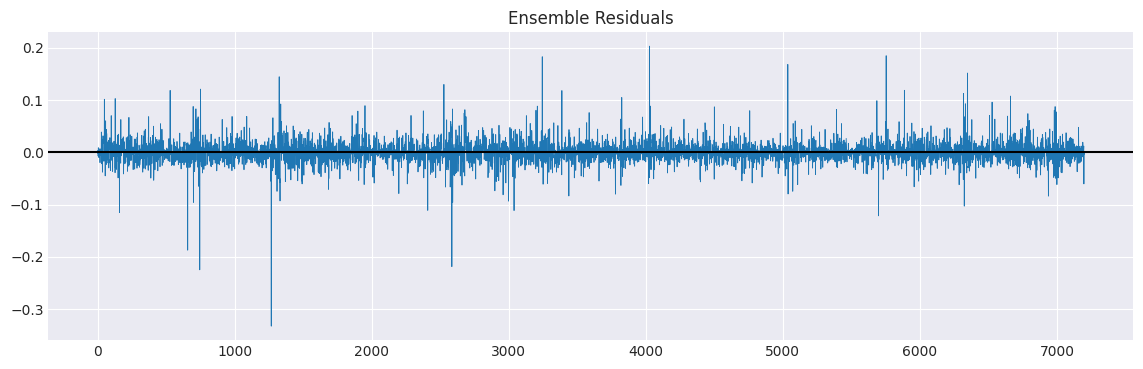

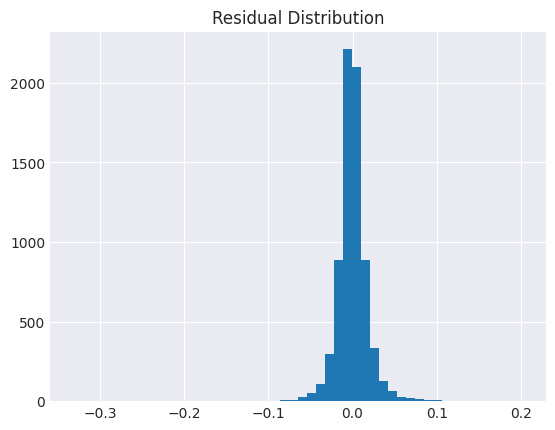

In [27]:
ens_preds_all = []
ens_truth_all = []

for rf_p, xgb_p, lgb_p, y_t in zip(
    rf_res["preds_raw_all"],
    xgb_res["preds_raw_all"],
    lgb_res["preds_raw_all"],
    rf_res["y_raw_all"],
):
    meta = np.vstack([rf_p, xgb_p, lgb_p]).T
    p = ridge.predict(meta)
    ens_preds_all.append(p)
    ens_truth_all.append(y_t)

ens_preds_all = np.concatenate(ens_preds_all)
ens_truth_all = np.concatenate(ens_truth_all)

resid = ens_truth_all - ens_preds_all

plt.figure(figsize=(14,4))
plt.plot(resid, linewidth=0.6)
plt.axhline(0, color="black")
plt.title("Ensemble Residuals")
plt.show()

plt.hist(resid, bins=50)
plt.title("Residual Distribution")
plt.show()


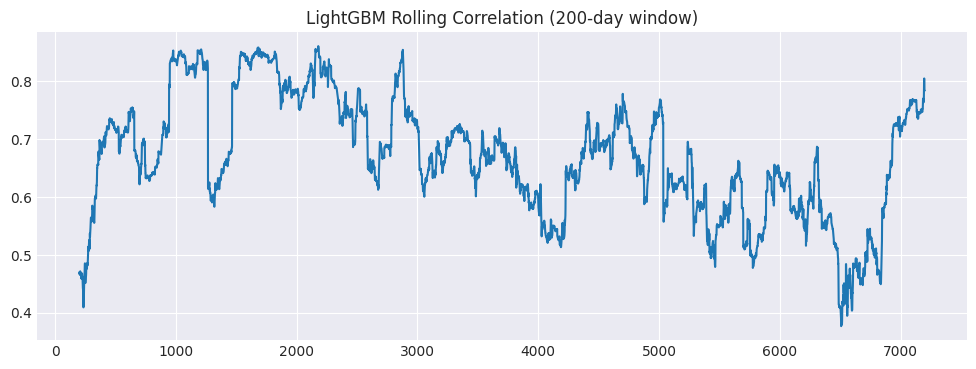

In [28]:
lgb_pred_all = np.concatenate(lgb_res["preds_raw_all"])
y_all        = np.concatenate(lgb_res["y_raw_all"])

rolling_corr = pd.Series(y_all).rolling(200).corr(pd.Series(lgb_pred_all))

plt.figure(figsize=(12,4))
rolling_corr.plot()
plt.title("LightGBM Rolling Correlation (200-day window)")
plt.show()


In [29]:
lgbm_full = lgb.LGBMRegressor(
    n_estimators=700, learning_rate=0.02,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42,
)

lgbm_full.fit(X, y)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 23140, number of used features: 19
[LightGBM] [Info] Start training from score 0.083180


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.02
,n_estimators,700
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


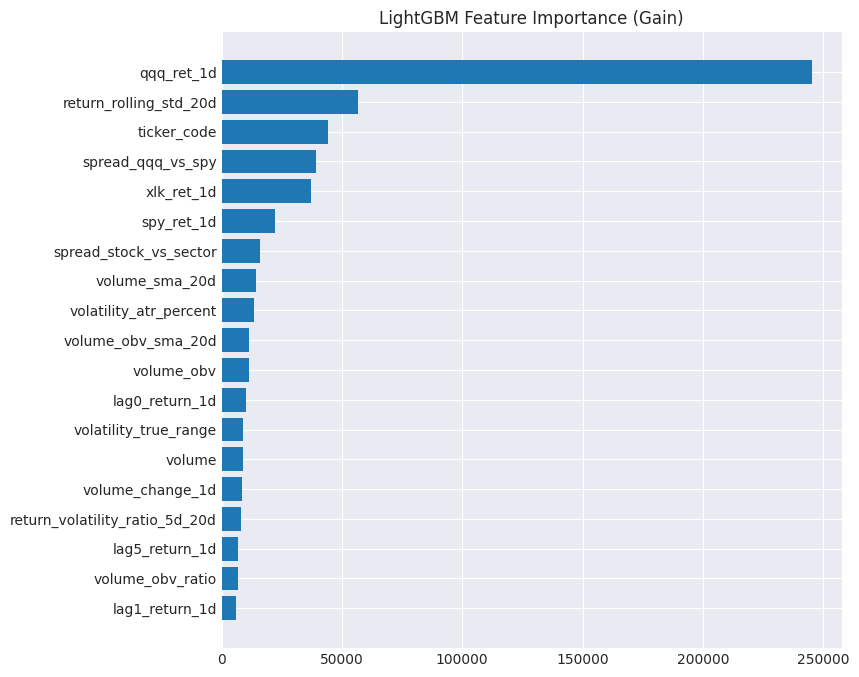

In [30]:
gain = lgbm_full.booster_.feature_importance(importance_type="gain")
names = lgbm_full.booster_.feature_name()

fi = pd.DataFrame({"feature": names, "gain": gain}) \
         .sort_values("gain", ascending=False)

fi.head(20)

plt.figure(figsize=(8, 8))
plt.barh(fi["feature"][:20][::-1], fi["gain"][:20][::-1])
plt.title("LightGBM Feature Importance (Gain)")
plt.show()


In [31]:
perm = permutation_importance(
    lgbm_full, X, y, n_repeats=20,
    random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

perm_df.head(20)


,feature,importance
1,qqq_ret_1d,0.679653
15,return_rolling_std_20d,0.189148
4,spread_qqq_vs_spy,0.102248
0,ticker_code,0.098291
5,spread_stock_vs_sector,0.042892
7,volume_obv_sma_20d,0.030742
18,volatility_atr_percent,0.029012
6,volume_obv,0.026678
17,volatility_true_range,0.025053
11,volume_change_1d,0.024288


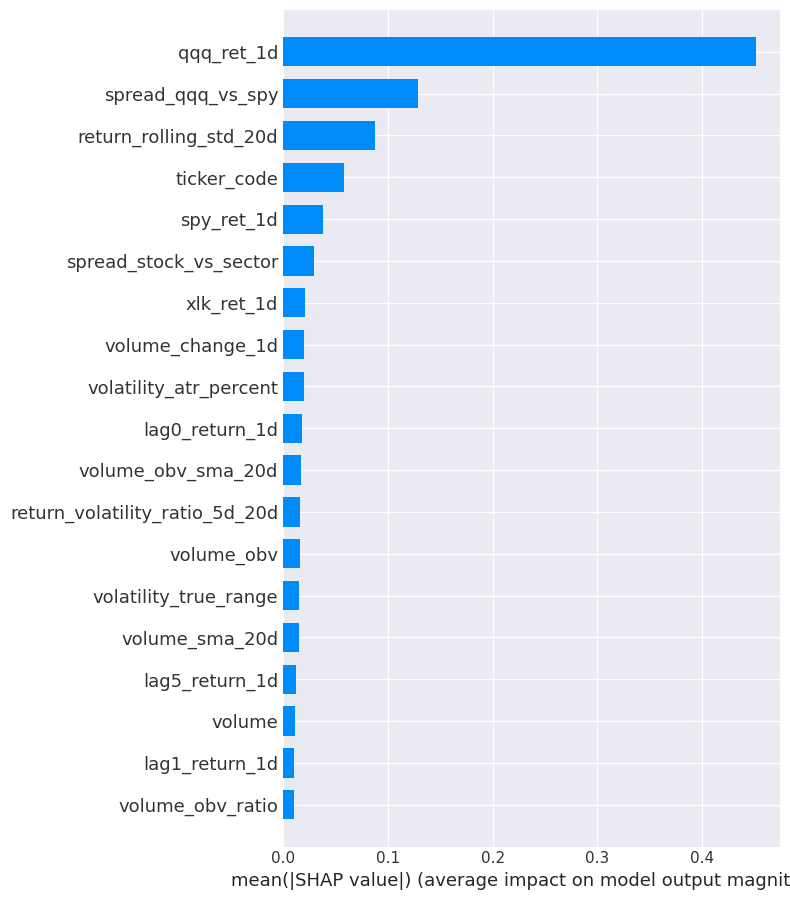

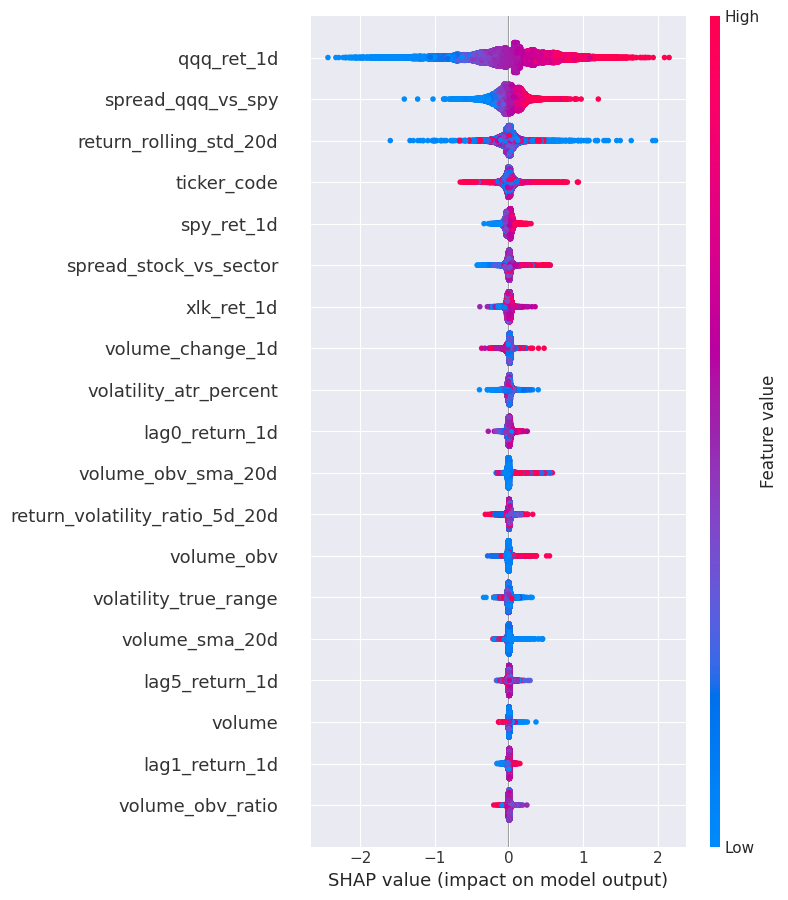

In [32]:
explainer = shap.TreeExplainer(lgbm_full)
shap_values = explainer.shap_values(X)

# global bar plot
shap.summary_plot(shap_values, X, plot_type="bar", max_display=20)

# detailed beeswarm plot
shap.summary_plot(shap_values, X, max_display=30)
